In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
param_grid = {'C': [10**k for k in range(-10, 6, 2)]}  
scoring = 'roc_auc'; cv = 3; random_state=42
random.seed(random_state)

In [3]:
with open("genre_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    genre_map = json.load(f)
aligned_genre = list(genre_map)[:-1]

with open("instrument_map.json", "r") as f: # only consider 10 classes of Openmic dataset
    instrument_map = json.load(f)

In [4]:
# use a Pandas DataFrame to record all results and save into a csv file later
result_all = pd.DataFrame({'instrument': [],
                          'train_set': [],
                          'test_set': [],
                          'precision': [],
                          'recall': [],
                          'f1-score': [],
                          'support': [],
                          'accuracy': [],
                          'roc_auc': [],
                          'ap': [],
                          'embedding': [],
                         })

# Load embeddings and align classes

In [5]:
embedding = 'openl3'
debias_method = '-lda-all'

# load embeddings
embeddings = h5py.File("embeddings.h5", "r")

In [6]:
###### IRMAS data ######
feature = np.array(embeddings["irmas"][embedding]["features"])
keys_ori = np.array(embeddings["irmas"][embedding]["keys"])
key_clip = np.unique(keys_ori)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [7]:
def load_feature(meta, feature_clip, key_clip):
    key_train = list(meta.loc[(meta['split'] == 'train')]['file_name'])
    key_test = list(meta.loc[(meta['split'] == 'test')]['file_name'])

    idx_train = [list(key_clip).index(item) for item in key_train]
    idx_test = [list(key_clip).index(item) for item in key_test]
   
    # cast the idx_* arrays to numpy structures
    idx_train = np.asarray(idx_train)
    idx_test = np.asarray(idx_test)

    # use the split indices to partition the features, labels, and masks
    X_train = feature_clip[idx_train,:]
    X_test = feature_clip[idx_test]

    Y_train = meta.loc[(meta['split'] == 'train')]['instrument'].values
    Y_test = meta.loc[(meta['split'] == 'test')]['instrument'].values

    genre_train = meta.loc[(meta['split'] == 'train')]['genre'].values
    genre_test = meta.loc[(meta['split'] == 'test')]['genre'].values

    return (X_train, Y_train), (X_test, Y_test), (genre_train, genre_test)

In [8]:
A_meta = pd.read_csv("A_meta.csv")
(X_train_A, Y_train_A), (X_test_A, Y_test_A), (genre_train_A, genre_test_A) = load_feature(A_meta, feature_clip, key_clip)
B_meta = pd.read_csv("B_meta.csv")
(X_train_B, Y_train_B), (X_test_B, Y_test_B), (genre_train_B, genre_test_B) = load_feature(B_meta, feature_clip, key_clip)

# A -> A

In [9]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'A', 'A' 

globals()['LDAcoef_' + train_set_name] = dict()

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in instrument_map:
    
    Y_train_A_inst = Y_train_A==instrument
    Y_train_B_inst = Y_train_B==instrument

    Y_test_A_inst = Y_test_A==instrument
    Y_test_B_inst = Y_test_B==instrument

    X_train_inst = X_train_A
    Y_train_inst = Y_train_A_inst
    X_test_inst = X_test_A
    Y_test_inst = Y_test_A_inst

    ############### LDA ###############
    X_train_conca = np.vstack((X_train_A, X_train_B))
    Y_A = np.zeros(len(X_train_A))
    Y_B = np.ones(len(X_train_B))
    Y_conca = np.hstack((Y_A, Y_B))

    LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    LDA.fit(X_train_conca, Y_conca)

    v = LDA.coef_.copy()
    v /= np.sqrt(np.sum(v**2))
    A = np.outer(v, v)

    X_train_inst = X_train_inst.copy().dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.copy().dot(np.eye(len(A)) - A)

    # save dataset separation direction
    globals()['LDAcoef_' + train_set_name][instrument] = LDA.coef_.copy()

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

with open('models/LDAcoef_' + train_set_name + '_' + embedding + debias_method + '.pickle', 'wb') as fdesc:
    pickle.dump(globals()['LDAcoef_'+train_set_name], fdesc)

----------------------------------------------------
cel
	TEST
              precision    recall  f1-score   support

       False       0.99      0.96      0.98       802
        True       0.58      0.86      0.69        49

    accuracy                           0.96       851
   macro avg       0.78      0.91      0.83       851
weighted avg       0.97      0.96      0.96       851

ROC-AUC = 0.983		AP = 0.804
----------------------------------------------------
cla
	TEST
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       787
        True       0.62      0.77      0.69        64

    accuracy                           0.95       851
   macro avg       0.80      0.86      0.83       851
weighted avg       0.95      0.95      0.95       851

ROC-AUC = 0.949		AP = 0.753
----------------------------------------------------
flu
	TEST
              precision    recall  f1-score   support

       False       0.98      0.94      0.96   

# A -> B

In [10]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'A', 'B' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in instrument_map:
    
    Y_train_A_inst = Y_train_A==instrument
    Y_train_B_inst = Y_train_B==instrument

    Y_test_A_inst = Y_test_A==instrument
    Y_test_B_inst = Y_test_B==instrument

    X_train_inst = X_train_A
    Y_train_inst = Y_train_A_inst
    X_test_inst = X_test_B
    Y_test_inst = Y_test_B_inst

    ############### LDA ###############
    X_train_conca = np.vstack((X_train_A, X_train_B))
    Y_A = np.zeros(len(X_train_A))
    Y_B = np.ones(len(X_train_B))
    Y_conca = np.hstack((Y_A, Y_B))

    LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    LDA.fit(X_train_conca, Y_conca)

    v = LDA.coef_.copy()
    v /= np.sqrt(np.sum(v**2))
    A = np.outer(v, v)

    X_train_inst = X_train_inst.copy().dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.copy().dot(np.eye(len(A)) - A)

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cel
	TEST
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       808
        True       0.62      0.84      0.71        49

    accuracy                           0.96       857
   macro avg       0.81      0.90      0.85       857
weighted avg       0.97      0.96      0.96       857

ROC-AUC = 0.972		AP = 0.779
----------------------------------------------------
cla
	TEST
              precision    recall  f1-score   support

       False       0.98      0.95      0.96       793
        True       0.52      0.70      0.60        64

    accuracy                           0.93       857
   macro avg       0.75      0.83      0.78       857
weighted avg       0.94      0.93      0.93       857

ROC-AUC = 0.914		AP = 0.621
----------------------------------------------------
flu
	TEST
              precision    recall  f1-score   support

       False       0.98      0.95      0.96   

# B -> B

In [11]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'B', 'B' 

globals()['LDAcoef_' + train_set_name] = dict()

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in instrument_map:
    
    Y_train_A_inst = Y_train_A==instrument
    Y_train_B_inst = Y_train_B==instrument

    Y_test_A_inst = Y_test_A==instrument
    Y_test_B_inst = Y_test_B==instrument

    X_train_inst = X_train_B
    Y_train_inst = Y_train_B_inst
    X_test_inst = X_test_B
    Y_test_inst = Y_test_B_inst

    ############### LDA ###############
    X_train_conca = np.vstack((X_train_A, X_train_B))
    Y_A = np.zeros(len(X_train_A))
    Y_B = np.ones(len(X_train_B))
    Y_conca = np.hstack((Y_A, Y_B))

    LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    LDA.fit(X_train_conca, Y_conca)

    v = LDA.coef_.copy()
    v /= np.sqrt(np.sum(v**2))
    A = np.outer(v, v)

    X_train_inst = X_train_inst.copy().dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.copy().dot(np.eye(len(A)) - A)

    # save dataset separation direction
    globals()['LDAcoef_' + train_set_name][instrument] = LDA.coef_.copy()

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

with open('models/LDAcoef_' + train_set_name + '_' + embedding + debias_method + '.pickle', 'wb') as fdesc:
    pickle.dump(globals()['LDAcoef_'+train_set_name], fdesc)

----------------------------------------------------
cel
	TEST
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       808
        True       0.62      0.84      0.71        49

    accuracy                           0.96       857
   macro avg       0.81      0.90      0.85       857
weighted avg       0.97      0.96      0.96       857

ROC-AUC = 0.980		AP = 0.814
----------------------------------------------------
cla
	TEST
              precision    recall  f1-score   support

       False       0.97      0.95      0.96       793
        True       0.53      0.64      0.58        64

    accuracy                           0.93       857
   macro avg       0.75      0.80      0.77       857
weighted avg       0.94      0.93      0.93       857

ROC-AUC = 0.908		AP = 0.675
----------------------------------------------------
flu
	TEST
              precision    recall  f1-score   support

       False       0.98      0.94      0.96   

# B -> A

In [12]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'B', 'A' 

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in instrument_map:
    
    Y_train_A_inst = Y_train_A==instrument
    Y_train_B_inst = Y_train_B==instrument

    Y_test_A_inst = Y_test_A==instrument
    Y_test_B_inst = Y_test_B==instrument

    X_train_inst = X_train_B
    Y_train_inst = Y_train_B_inst
    X_test_inst = X_test_A
    Y_test_inst = Y_test_A_inst

    ############### LDA ###############
    X_train_conca = np.vstack((X_train_A, X_train_B))
    Y_A = np.zeros(len(X_train_A))
    Y_B = np.ones(len(X_train_B))
    Y_conca = np.hstack((Y_A, Y_B))

    LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')
    LDA.fit(X_train_conca, Y_conca)

    v = LDA.coef_.copy()
    v /= np.sqrt(np.sum(v**2))
    A = np.outer(v, v)

    X_train_inst = X_train_inst.copy().dot(np.eye(len(A)) - A)
    X_test_inst = X_test_inst.copy().dot(np.eye(len(A)) - A)

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=random_state, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_train_inst)

    # predict
    Y_pred_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_scores = clf.predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_test_inst, Y_pred_inst))
    
    model_auc = roc_auc_score(Y_test_inst, Y_pred_scores)
    model_ap = average_precision_score(Y_test_inst, Y_pred_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_test_inst, Y_pred_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap, embedding + debias_method]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cel
	TEST
              precision    recall  f1-score   support

       False       1.00      0.97      0.98       802
        True       0.66      0.94      0.77        49

    accuracy                           0.97       851
   macro avg       0.83      0.95      0.88       851
weighted avg       0.98      0.97      0.97       851

ROC-AUC = 0.986		AP = 0.794
----------------------------------------------------
cla
	TEST
              precision    recall  f1-score   support

       False       0.98      0.96      0.97       787
        True       0.61      0.75      0.67        64

    accuracy                           0.94       851
   macro avg       0.79      0.86      0.82       851
weighted avg       0.95      0.94      0.95       851

ROC-AUC = 0.919		AP = 0.697
----------------------------------------------------
flu
	TEST
              precision    recall  f1-score   support

       False       0.99      0.93      0.96   

# save result

In [13]:
# save all result into a csv file
# result_all.to_csv('results/result_' + embedding + debias_method + '_trainboth.csv', index=False)
# result_all.to_csv('results/result_' + embedding +  debias_method + '.csv', index=False)

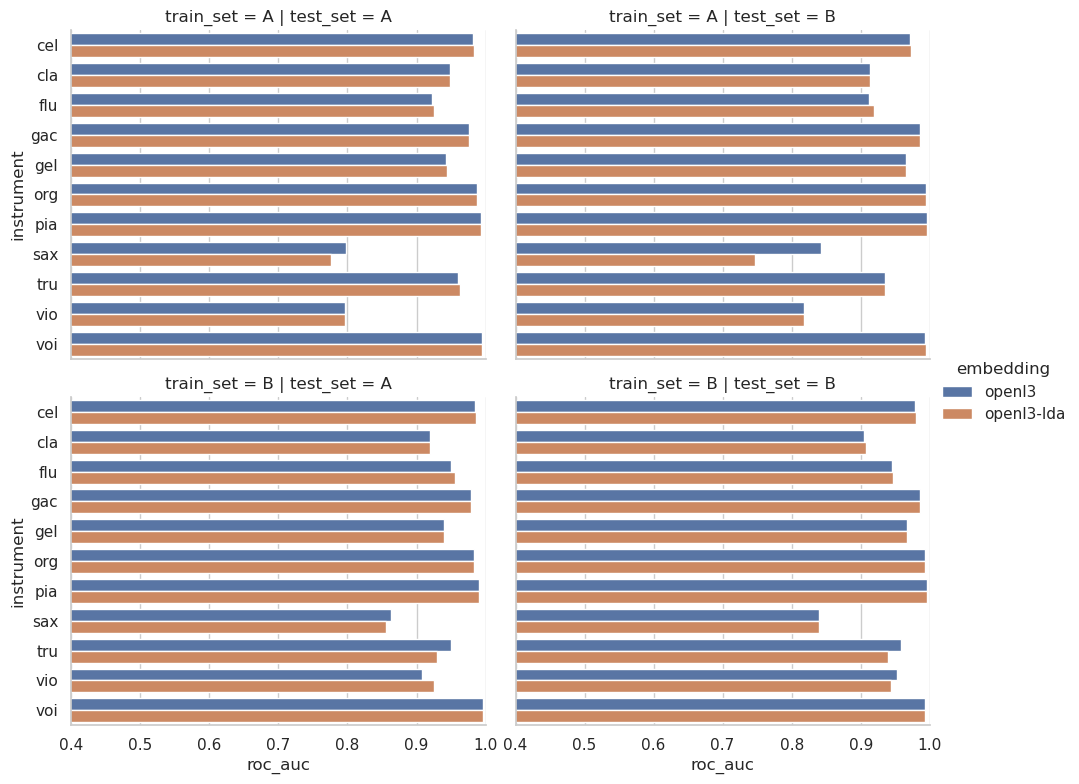

In [14]:
# save all result into a csv file
df_1 = pd.read_csv('results/result_' + embedding + '.csv')

df = df_1.append(result_all)
df.to_csv('results/result_' + embedding  + debias_method + '.csv', index=False)

df = pd.read_csv('results/result_' + embedding  + debias_method + '.csv')

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2)
plt.xlim([0.4,1])
plt.savefig('results/' + embedding  + debias_method + '.pdf')